In [1]:
source("paper_utils.R")

In [2]:
library(uwot)
library(ggridges)
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}



Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual



In [3]:
# nice_names <- data.frame()
names_list <- c(arterial = 'Arterial EC', venous = 'Venous EC', chondrocytes = 'Chondrocytes', 
                intermediate = 'Intermediate Fibroblasts', 'lining' = 'Lining Fibroblasts', myeloid = 'Myeloid', 
                neutrophil = 'Neutrophils', pericyte_VSMC = 'Pericytes/VSMCs', sublining = 'Sublining Fibroblasts', 
                tcell = 'T cells', bcell = 'B cells')
nice_names <- data.frame(nice_name = names_list, stringsAsFactors = FALSE) %>% 
    tibble::rownames_to_column('given_name')

In [4]:
library(patchwork)
library(ggthemes)

plotFeatures <- function(data_mat, dim_df, features, nrow = 1, w = 6, h = 4,
                         qlo = 0.05, qhi = 1, order_by_expression = FALSE, 
                         pt_shape = 16, pt_size = .5, no_guide = FALSE,
                         .xlim = c(NA, NA), .ylim = c(NA, NA), color_high = muted('blue')) {
    plt_df <- data.frame(dim_df[, 1:2])
    colnames(plt_df) <- c("X1", "X2")


    plt_list <- lapply(features, function(feature) {
        .x <- setupVals(data_mat, feature, qlo, qhi)
        plt_df$value <- 0
        plt_df[.x@j + 1, "value"] <- .x@x
        if (order_by_expression) {
            plt_df %<>% dplyr::arrange(value)             
        } else {
            plt_df %<>% dplyr::sample_frac(1L)
        }

        plt <- plt_df %>% 
            ggplot(aes(X1, X2, color = value)) + 
            geom_point_rast(dpi = 300, width = w, height = h, size = 1, shape = pt_shape) + 
#             geom_point(shape = ".") + 
            scale_color_gradient2(na.value = "lightgrey", mid = "lightgrey", midpoint = 0, high = color_high) + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + 
            theme(panel.background = element_rect(), plot.title = element_text(hjust = .5)) +
            labs(x = "UMAP 1", y = "UMAP 2", title = feature) + 
            NULL
        if (no_guide) {
            plt <- plt + 
            guides(color = FALSE) 
        }
        
        if (sum(is.na(.xlim)) < 2) 
            plt <- plt + xlim(.xlim)
        if (sum(is.na(.ylim)) < 2) 
            plt <- plt + ylim(.ylim)
        plt

    })
    if (length(plt_list) > 1) {
        Reduce(`+`, plt_list) + patchwork::plot_layout(nrow = nrow)
    } else {
        plt_list[[1]]
    }
}


In [5]:
bin_95 <- function(data_df, xvar, yvars, num.bin) {
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    
    .breaks <- unique(quantile(x, probs=seq(0, 1, length.out=num.bin)))
    bin_means <- .5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest=TRUE)
    levels(bins_freq) <- bin_means 
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% as.numeric
    
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]        
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% as.numeric
        data.frame(xval = xmeans) %>% 
            cbind(
                Reduce(rbind, lapply(split(y, as.integer(bins_freq)), function(.x) quantile(.x, c(.05, .95)))) %>% 
                    data.frame() %>% 
                    dplyr::mutate(symbol = yvar)
            ) %>% 
            cbind(yval = ymeans, ysd = ysd)
             
    })) %>% data.frame()
    return(res_df)
}

# Load data

In [6]:
read10x <- function(run, suffix) {
    gene.loc <- list.files(run, pattern = 'features|genes', full.names = TRUE)
    barcode.loc <- list.files(run, pattern = 'barcodes', full.names = TRUE)
    matrix.loc <- list.files(run, pattern = 'matrix', full.names = TRUE)
    
    data <- readMM(file = matrix.loc) %>% as("dgCMatrix")
    cell.names <- readLines(barcode.loc)
    cell.names <- gsub("-1$", "", cell.names)
    if (!missing(suffix)) {
        cell.names %<>% paste(suffix, sep = "_")
    }
    
    gene.names <- fread(gene.loc, header = FALSE)$V2
    row.names(data) <- gene.names
    colnames(data) <- cell.names

    return(as(sumOverRowNames(data), "dgCMatrix"))
}


In [17]:
dir_names <- c(
    '/data/srlab/bwh10x/180911_KW6049_10x_rawbcl/cellranger-3.0.2/mm10/BRI-062/outs/filtered_feature_bc_matrix/',
    '/data/srlab/bwh10x/180911_KW6049_10x_rawbcl/cellranger-3.0.2/mm10/BRI-063/outs/filtered_feature_bc_matrix/',
    '/data/srlab/bwh10x/181016_KW6178_10x_rawbcl/cellranger-3.0.2/mm10/BRI-069/outs/filtered_feature_bc_matrix/',
    '/data/srlab/bwh10x/181016_KW6178_10x_rawbcl/cellranger-3.0.2/mm10/BRI-070/outs/filtered_feature_bc_matrix/',
    '/data/srlab/bwh10x/190124_KW6582_10x_rawbcl/cellranger-3.0.2/mm10/BRI-151/outs/filtered_feature_bc_matrix/',
    '/data/srlab/bwh10x/190308_KW6736_10x_rawbcl/cellranger-3.0.2/mm10/BRI-203/outs/filtered_feature_bc_matrix/'
)

sample_names <- c("BRI062", "BRI063", "BRI069", "BRI070", "BRI151", "BRI203")

In [18]:
x <-lapply(1:length(dir_names), function(i) {
    message(i)
    read10x(dir_names[i], sample_names[i])
})
genes_common <- Reduce(intersect, lapply(x, row.names))
exprs_raw <- Reduce(Matrix::cbind2, lapply(x, function(y) y[genes_common, ]))

1
2
3
4
5
6


In [20]:
meta_raw <- data.frame(cell_id = colnames(exprs_raw)) %>% 
    dplyr::mutate(donor = gsub("^(.*)_(.*)", "\\2", cell_id))
table(meta_raw$donor)

meta_raw$nUMI <- Matrix::colSums(exprs_raw)
meta_raw$nGene <- Matrix::colSums(exprs_raw > 0)
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_raw$percent_mito <- Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)

meta_data <- subset(meta_raw, nGene > 500 & percent_mito < .2)
nrow(meta_raw); nrow(exprs_raw)
# table(meta_data$donor)


BRI062 BRI063 BRI069 BRI070 BRI151 BRI203 
  2751   2766   3549   2273   5330   3157 

[1] 19826

[1] 31017

In [21]:
meta_data %<>% 
    dplyr::inner_join(
        data.table(donor = c("BRI062", "BRI063", "BRI069", "BRI070", "BRI151", "BRI203"), 
                   label = c('WT', 'KO', 'ISO', 'N3', 'KO', 'WT'))
    )

Joining, by = "donor"


In [22]:
meta_data %<>% 
    dplyr::inner_join(
        data.table(donor = c("BRI062", "BRI063", "BRI069", "BRI070", "BRI151", 'BRI203'), 
                   status = c('case', 'case', 'case', 'case', 'ctrl', 'ctrl'))
    )

Joining, by = "donor"


# Basic analysis

Alternatively, just use V2 data

In [12]:
library(singlecellmethods)
genes_use <- which(Matrix::rowSums(exprs_raw != 0) >= 10)
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% singlecellmethods::normalizeData(method = 'log')
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, as.integer(factor(meta_data$donor)), num.bin = 20)

In [13]:
mouse <- list()
mouse$meta_data <- meta_data
mouse$exprs_norm <- exprs_norm

In [14]:
dim(mouse$exprs_norm)

[1] 16492 18491

In [15]:
table(mouse$meta_data$donor)


BRI062 BRI063 BRI069 BRI070 BRI151 BRI203 
  2452   2666   3191   2109   5096   2977 

In [16]:
with(mouse, {
    vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
    var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
    
    ## TODO: fix this later. Some gene names get "fixed" by R 
    var_genes <- intersect(var_genes, row.names(exprs_norm))
    
    pca_res <- exprs_norm[var_genes, ] %>% 
        singlecellmethods::scaleData() %>% 
        rARPACK::svds(30, 0, 30)
    V <- pca_res$v %*% diag(pca_res$d)
    umap_res <- umap(V, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
                     min_dist = .3, n_threads = 4, approx_pow = TRUE)
    
    mouse$pca_res <<- pca_res
    mouse$V <<- V
    mouse$umap <<- umap_res
})


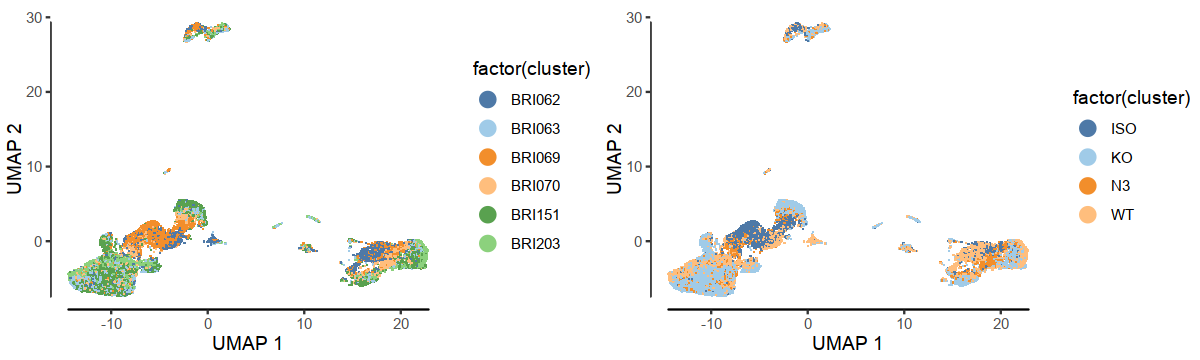

In [17]:
fig.size(3, 10)
with(mouse, {
    plot_clusters3(meta_data$donor, pt_size = 5, umap_use = umap, do_labels = FALSE, min_cluster_size = 0) + 
    plot_clusters3(meta_data$label, pt_size = 5, umap_use = umap, do_labels = FALSE, min_cluster_size = 0) 
})


# Harmony

In [18]:
fig.size(3, 6)
library(harmony)
with(mouse, {
    harmonyObj <- HarmonyMatrix(V, meta_data, c("donor"), theta = 1, do_pca = FALSE, 
                                 lambda = .1, epsilon.harmony = -Inf,
                                 max.iter.cluster = 20, max.iter.harmony = 10,
                                 nclust = 50, plot_convergence = FALSE, return_object = TRUE)
    obj <<- harmonyObj    
    mouse$Z_cos <<- harmonyObj$Z_cos
    mouse$Z_corr <<- harmonyObj$Z_corr
    mouse$R <<- harmonyObj$R
})

Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony 6/10
Harmony 7/10
Harmony 8/10
Harmony 9/10
Harmony 10/10
start umap


In [19]:
with(mouse, {
    mouse$umap_harmony <<- umap(t(Z_corr), n_neighbors = 30, learning_rate = 0.5, 
                                 init = "laplacian", metric = 'cosine',
                                 min_dist = .1, n_threads = 4, approx_pow = TRUE)
})

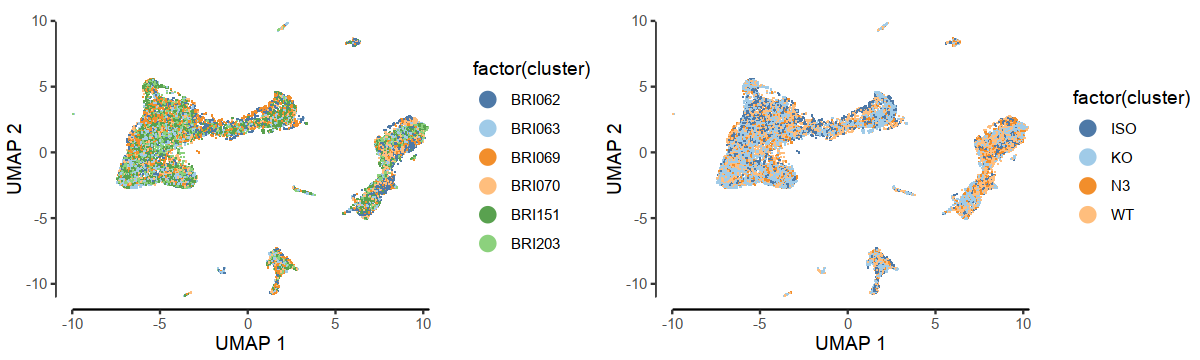

In [20]:
fig.size(3, 10)
with(mouse, {
    plot_clusters3(meta_data$donor, pt_size = 5, umap_use = umap_harmony, do_labels = FALSE, min_cluster_size = 0) + 
    plot_clusters3(meta_data$label, pt_size = 5, umap_use = umap_harmony, do_labels = FALSE, min_cluster_size = 0)    
})


# Major cell types

In [21]:
library(singlecellmethods)
mouse$snn <- buildSNN_fromFeatures(t(mouse$Z_cos), 0, 30)
mouse$ids_ref <- singlecellmethods:::leidenCluster(
    mouse$snn, c(0.01, .02, .0001), min_cluster_size = 10, verbose = TRUE, 
    pythondir = "/PHShome/ik936/anaconda3/bin/python")    

Resolution 0.010000 yielded 11 clusters
Resolution 0.020000 yielded 16 clusters
Resolution 0.000100 yielded 3 clusters


In [22]:
apply(mouse$ids_ref, 2, function(x) length(unique(x)))
apply(mouse$ids_ref, 2, table)

res_1.0000e-02 res_2.0000e-02 res_1.0000e-04 
            11             16              3

$`res_1.0000e-02`

   1    2    3    4    5    6    7    8    9   10   11 
5389 4043 2961 1890 1653 1212  392  387  304  133  127 

$`res_2.0000e-02`

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
3925 2947 2279 2004 1621 1611 1501  864  387  348  304  208  185  133  129   45 

$`res_1.0000e-04`

    1     2     3 
11712  5440  1339 


In [24]:
## get 33 unique colors
colors_overload <- union(ggthemes::tableau_color_pal('Tableau 20')(20), RColorBrewer::brewer.pal(12, 'Set3'))
colors_overload <- c(colors_overload, 'black')

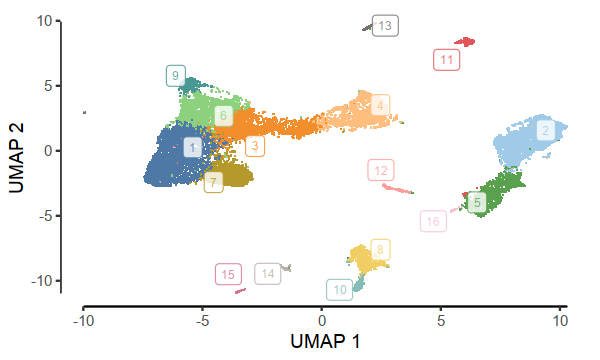

In [27]:
fig.size(3, 5)
with(mouse, {
    plot_clusters3(ids_ref[, 2], pt_size = 2.5, do_labels = TRUE, 
                   umap_use = umap_harmony, min_cluster_size = 10, palette_use = colors_overload) 
})

## Split the EC cluster

In [116]:
idx_ec <- which(mouse$ids_ref[, 1] == 7)
message(length(idx_ec))
snn_ec <- buildSNN_fromFeatures(t(mouse$Z_cos[, idx_ec]), 0, 30)
ids_ec <- leidenCluster(
    snn_ec, c(0.01, .02, .0001), min_cluster_size = 10, verbose = TRUE, 
    pythondir = "/PHShome/ik936/anaconda3/bin/python")    

1736
Resolution 0.010000 yielded 1 clusters
Resolution 0.020000 yielded 2 clusters
Resolution 0.000100 yielded 1 clusters


In [127]:
clusters <- mouse$ids_ref[, 2]
clusters[idx_ec] <- ids_ec[, 2] + max(mouse$ids_ref[, 2], na.rm = TRUE)

In [130]:
table(clusters)

clusters
   1    2    3    4    5    6    7    8   10   11   13   14   15   16   17   18 
5595 4244 4086 2931 2340 2064 1395 1326  592  582  376  293  269  220  196  165 
  19   20   21   22   23 
  84   52   18 1293  443 

In [31]:
clusters <- mouse$ids_ref[, 2]

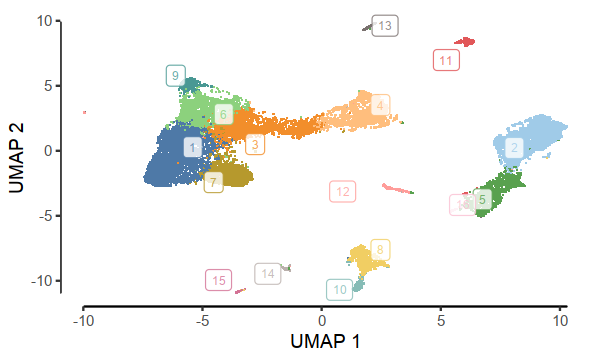

In [32]:
fig.size(3, 5)
with(mouse, {
    plot_clusters3(clusters, pt_size = 2.5, do_labels = TRUE, umap_use = umap_harmony, min_cluster_size = 10, 
                   palette_use = colors_overload) 
})

## DGEs

In [33]:
library(Presto)
markers <- Presto::wilcoxauc(mouse$exprs_norm, clusters)


Attaching package: ‘Presto’

The following objects are masked _by_ ‘.GlobalEnv’:

    nnzeroGroups, sumGroups



## Scatterplot

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE


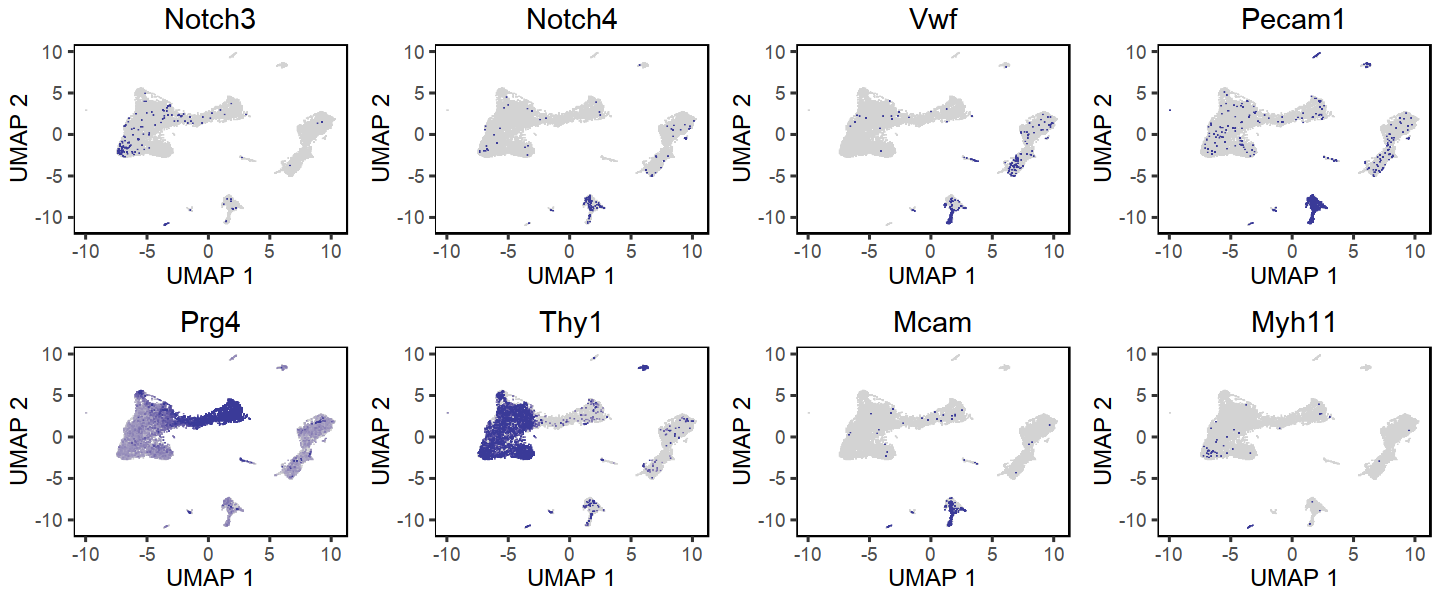

In [30]:
# features <- paste0('Notch', 1:4)
features <- c('Notch3', 'Notch4', 'Vwf', 'Pecam1', 'Prg4', 'Thy1', 'Mcam', 'Myh11')

fig.size(5, 12)
with(mouse, {
    print(features %in% row.names(exprs_norm))
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, no_guide = TRUE, w = 2, h = 1.5,
                 features, nrow = 2, qlo = 0, qhi = .9, pt_shape = '.')
})


## Notch1 FeaturePlot

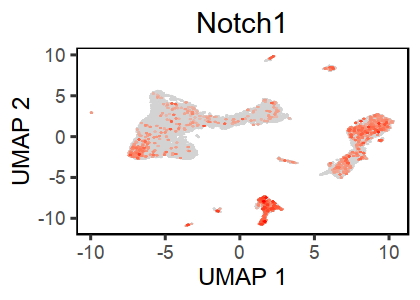

In [230]:
# features <- paste0('Notch', 1:4)
features <- c('Notch1')

fig.size(2.5, 3.5)
with(mouse, {
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 2, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red')
})


ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/mouse_notch1_scatter.pdf', device = "pdf", 
       dpi = 300, width = 3.5, height = 2.5, useDingbats = FALSE)  


## Call cell clusters


In [35]:
name_clusters <- function(name_list, clusters) {
        cluster_labels <- Reduce(rbind, lapply(names(name_list), function(y) {
            data.table(cell_type = y, cluster_ids = name_list[[y]])
        }))
        data.table(cluster_ids = clusters) %>%
            dplyr::left_join(cluster_labels, by = "cluster_ids") %>% 
            dplyr::select(-cluster_ids) %>% 
            with(cell_type)
}

In [44]:
name_list <- list(
    lining = c(4), 
    intermediate = c(3),
    sublining = c(1, 6, 7, 9), 
#     perivascular = c(), 
#     adipocyte_like = c(),
    pericyte_VSMC = c(15), 
    myeloid = c(2, 5, 16),
    venous = c(10), 
    arterial = c(8),
#     endothelial = c(), 
    tcell = c(11),
    bcell = c(13),
    neutrophil = c(14),
    chondrocytes = c(12),
#     lymphocyte = c(),
    `NA` = NA
)

length(name_clusters(name_list, clusters))
nrow(mouse$meta_data)


mouse$meta_data$cell_type <- name_clusters(name_list, clusters)

[1] 18491

[1] 18491

# Notch activation score

Hypothesis: notch activation in pericytes should track with phenotype. 

Within RA model, N3KO < anti-N3 < WT/ISO

    N3KO has no potential for Notch response (unless through other Notch receptors) 
    anti-N3 has potential but should be blocked
    



## compute score for each cell

In [24]:
# mouse <- readRDS('/data/srlab/ik936/NOTCH/data/cache/mouse.rds')
ortho <- fread('/data/srlab/ik936/NOTCH/data/human_mouse_dict.csv') 
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"
bulk <- readRDS(file.path(cachedir, "bulk_data.rds"))
table(mouse$meta_data$label)


ERROR: Error in table(mouse$meta_data$label): object 'mouse' not found


In [ ]:
with(bulk, {
    genes_dll4 <- dge_dll4 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) 
    genes_dll4 <- ortho %>% subset(human %in% genes_dll4) %>% with(mouse) %>% 
        intersect(row.names(mouse$exprs_norm))
    
    genes_jag1 <- dge_jag1 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) 
    genes_jag1 <- ortho %>% subset(human %in% genes_jag1) %>% with(mouse) %>% 
        intersect(row.names(mouse$exprs_norm))
    
    genes_both <- union(genes_dll4, genes_jag1)
    message(length(genes_jag1))
    message(length(genes_dll4))
    message(length(genes_both))


    ## Naive score computation
    .x <<- data.table(
        score_jag1 = Matrix::colSums(mouse$exprs_norm[genes_jag1, ]),
        score_dll4 = Matrix::colSums(mouse$exprs_norm[genes_dll4, ]),
        score_both = Matrix::colSums(mouse$exprs_norm[genes_both, ])
    ) %>% 
        cbind(mouse$meta_data)
})

In [279]:
mouse$meta_data$score_notch <- .x$score_both

In [49]:
table(mouse$meta_data$cell_type)


     arterial         bcell  chondrocytes  intermediate        lining 
          864           185           208          2279          2004 
      myeloid    neutrophil pericyte_VSMC     sublining         tcell 
         4613           133           129          7424           304 
       venous 
          348 

### Wilcoxon

In [163]:
labels <- unique(plt_df$label_nice)
wilcox_res <- Reduce(rbind, lapply(labels, function(l1) {
    Reduce(rbind, lapply(setdiff(labels, l1), function(l2) {
        wilcox.test(
            data.table(plt_df)[label_nice == l1, val],
            data.table(plt_df)[label_nice == l2, val]
        ) %>% 
        broom::tidy() %>% 
            dplyr::mutate(group1 = l1, group2 = l2)
        
    })) 
})) 

In [164]:
wilcox_res %>% subset(group1 == 'Wild-type\n(healthy)') %>% dplyr::arrange(p.value)

statistic,p.value,method,alternative,group1,group2
<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
32,0.006447291,Wilcoxon rank sum test,two.sided,Wild-type (healthy),Wild-type (arthritic)
264,0.039458443,Wilcoxon rank sum test,two.sided,Wild-type (healthy),Notch3-/- (healthy)
123,0.097520865,Wilcoxon rank sum test,two.sided,Wild-type (healthy),Isotype (arthritic)
161,0.099994998,Wilcoxon rank sum test,two.sided,Wild-type (healthy),anti-Notch3 (arthritic)
298,0.122838807,Wilcoxon rank sum test,two.sided,Wild-type (healthy),Notch3-/- (arthritic)


In [166]:
wilcox_res %>% subset(group1 == 'Wild-type\n(arthritic)') %>% dplyr::arrange(p.value)

statistic,p.value,method,alternative,group1,group2
<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
352,1.995854e-05,Wilcoxon rank sum test,two.sided,Wild-type (arthritic),Notch3-/- (arthritic)
284,7.614866e-05,Wilcoxon rank sum test,two.sided,Wild-type (arthritic),Notch3-/- (healthy)
174,8.931335e-04,Wilcoxon rank sum test,two.sided,Wild-type (arthritic),anti-Notch3 (arthritic)
136,6.447291e-03,Wilcoxon rank sum test,two.sided,Wild-type (arthritic),Wild-type (healthy)
194,2.427125e-01,Wilcoxon rank sum test,two.sided,Wild-type (arthritic),Isotype (arthritic)


In [205]:
wilcox_res %>% subset(group1 == 'Isotype\n(arthritic)') %>% dplyr::arrange(p.value)

statistic,p.value,method,alternative,group1,group2
<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
663,0.0002437389,Wilcoxon rank sum test,two.sided,Isotype (arthritic),Notch3-/- (arthritic)
550,0.0002697757,Wilcoxon rank sum test,two.sided,Isotype (arthritic),Notch3-/- (healthy)
332,0.0051572355,Wilcoxon rank sum test,two.sided,Isotype (arthritic),anti-Notch3 (arthritic)
241,0.0975208652,Wilcoxon rank sum test,two.sided,Isotype (arthritic),Wild-type (healthy)
118,0.2427125495,Wilcoxon rank sum test,two.sided,Isotype (arthritic),Wild-type (arthritic)


# antiN3 vs N3KO

Hypothesis: antiN3 affects the same genes as N3KO, compared to WT/ISO. 

Only in the V2 data, compare KO_v_WT and N3_v_ISO. The changes should be similar. 

## DGEs

First, KO vs WT

In [170]:
types_use <- unique(mouse$meta_data$cell_type) %>% setdiff(c(NA, '', 'NA'))
dge <- Reduce(rbind, lapply(types_use, function(type_use) {
    message(type_use)
    idx <- which(mouse$meta_data$status == 'case' & 
                 mouse$meta_data$cell_type == type_use &  
                 mouse$meta_data$label %in% c('WT', 'KO'))
    dge_ko <- wilcoxauc(mouse$exprs_norm[, idx], mouse$meta_data$label[idx]) %>% 
        subset(group == 'KO') %>% 
        dplyr::select(-group)    

    idx <- which(mouse$meta_data$status == 'case' & 
                 mouse$meta_data$cell_type == type_use &  
                 mouse$meta_data$label %in% c('ISO', 'N3'))

    dge_mab <- wilcoxauc(mouse$exprs_norm[, idx], mouse$meta_data$label[idx]) %>% 
        subset(group == 'N3') %>% 
        dplyr::select(-group)

    dplyr::inner_join(dge_ko, dge_mab, by = c('feature'), suffix = c('_ko', '_mab')) %>% 
        dplyr::mutate(cell_type = type_use)
    
}))



sublining
lining
tcell
myeloid
intermediate
venous
neutrophil
bcell
chondrocytes
pericyte_VSMC
arterial


In [171]:
suppressWarnings({
    cor_res <- data.table(dge)[
#         padj_ko < .05 | padj_mab < .05, 
        ,
        broom::tidy(cor.test(~ logFC_ko + logFC_mab, method = 'spearman')), 
        by = cell_type
    ][
        order(-estimate)
    ]
})
    

# Cache

In [280]:
saveRDS(mouse, '/data/srlab/ik936/NOTCH/data/cache/mouse.rds')